In [1]:
import numpy as np
import pandas as pd;
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Hypothesis Testing for Dropout/Graduate Students

> #### The objective here is to determine whether our observed differences between dropout students and those who graduated or are still enrolled are statistically significant

##### Setup

In [7]:
# loading data - dataframe from Leena_EDA 
df1 = pd.read_csv('Leena_df1Clean.csv')

# creating dataframe with relative frequencies for each target 
df1_grad = df1[df1['Target'] == 'Graduate/Enrolled']
df1_drop = df1[df1['Target'] == 'Dropout']

##### Storing relative frequencies for desired features (adopted from Leena_EDA)

In [10]:
    #marital_status
marital_status = pd.crosstab(df1['Target'], df1['Marital Status'])
marital_status_relfreq_drop = marital_status.loc['Dropout'] / df1_drop.shape[0]
marital_status_relfreq_grad = marital_status.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #previous qualification
prev_qual = pd.crosstab(df1['Target'], df1['Previous qualification'])
prev_qual_relfreq_drop = prev_qual.loc['Dropout'] / df1_drop.shape[0]
prev_qual_relfreq_grad = prev_qual.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #isDisplaced
displaced = pd.crosstab(df1['Target'], df1['isDisplaced'])
displaced_relfreq_drop = displaced.loc['Dropout'] / df1_drop.shape[0]
displaced_relfreq_grad = displaced.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #hasScholarship
hasScholarship = pd.crosstab(df1['Target'], df1['hasScholarship'])
hasScholarship_relfreq_drop = hasScholarship.loc['Dropout'] / df1_drop.shape[0]
hasScholarship_relfreq_grad = hasScholarship.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #isDebtor
isDebtor = pd.crosstab(df1['Target'], df1['isDebtor'])
isDebtor_relfreq_drop = isDebtor.loc['Dropout'] / df1_drop.shape[0]
isDebtor_relfreq_grad = isDebtor.loc['Graduate/Enrolled'] / df1_grad.shape[0]

In [18]:
df1.head()

,Marital Status,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Gender,...,Inflation rate,GDP,Target,isDisplaced,hasSpecialNeeds,tuitionToDate,hasScholarship,isDebtor,AttendanceTime,Nationality
0,Single,Animation and Multimedia Design,Secondary,122.0,Basic,Basic,5,9,127.3,Male,...,1.4,1.74,Dropout,True,False,True,False,False,Day,Portuguese
1,Single,Tourism,Secondary,160.0,Secondary,Higher,3,3,142.5,Male,...,-0.3,0.79,Graduate/Enrolled,True,False,False,False,False,Day,Portuguese
2,Single,Communication Design,Secondary,122.0,Basic,Basic,9,9,124.8,Male,...,1.4,1.74,Dropout,True,False,False,False,False,Day,Portuguese
3,Single,Journalism and Communication,Secondary,122.0,Basic,Basic,5,3,119.6,Female,...,-0.8,-3.12,Graduate/Enrolled,True,False,True,False,False,Day,Portuguese
4,Married,Social Service (evening attendance),Secondary,100.0,Basic,Basic,9,9,141.5,Female,...,-0.3,0.79,Graduate/Enrolled,False,False,True,False,False,Evening,Portuguese


> Assume that dropout students graduate students both follow a **normal distribution**


## Marital Status

> #### Were more dropout students married (or once married) than students who graduated?

Let $\theta$ = The difference between the proportion of married/divorced dropout students with graduated/enrolled students

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta > 0$
> _The difference could not have occured from chance alone, and the students came from a different population._

In [25]:
# calculating sample statistic 
sample_stat = (marital_status_relfreq_drop['Divorced'] + marital_status_relfreq_drop['Married']) - (marital_status_relfreq_grad['Divorced'] + marital_status_relfreq_grad['Married'])
sample_stat

0.07260719575990511

##### Running the simulation

In [96]:
def marital_diff_in_prop(shuffled_df):
    freq_table = pd.crosstab(shuffled_df['Shuffled'], shuffled_df['Marital Status'])
    
    drop_rel_freq = freq_table.loc['Dropout'] / df1_drop.shape[0]
    grad_rel_freq = freq_table.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    drop_prop = drop_rel_freq['Married'] + drop_rel_freq['Divorced']
    grad_prop = grad_rel_freq['Married'] + grad_rel_freq['Divorced']

    return (drop_prop - grad_prop)

In [97]:
marital_df = df1[['Marital Status', 'Target']]
simulated_diffs = np.array([])
n = 500

for i in range(n):
    shuffled_target = np.random.permutation(marital_df.get('Target'))
    with_shuffled = marital_df.assign(Shuffled=shuffled_target)
    stat = marital_diff_in_prop(with_shuffled)
    simulated_diffs = np.append(simulated_diffs, stat)

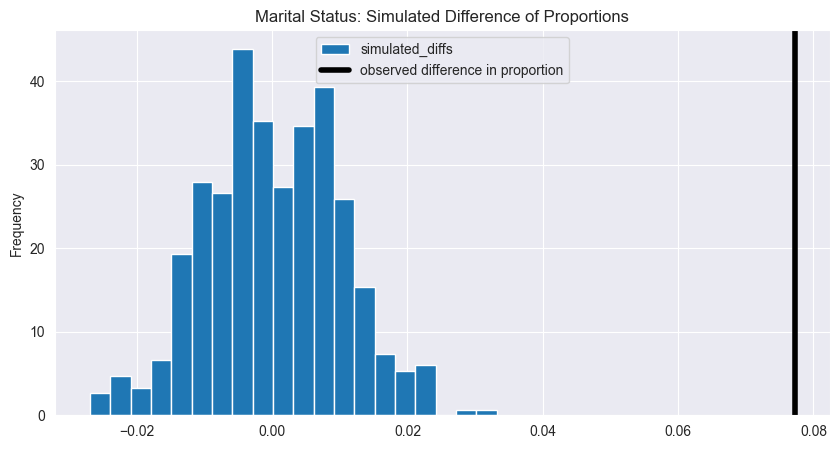

In [98]:
sns.set_style('darkgrid')

(pd.DataFrame()
 .assign(simulated_diffs=simulated_diffs)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(sample_stat, color='black', linewidth=4, label='observed difference in proportion')
plt.title('Marital Status: Simulated Difference of Proportions')
plt.legend();

In [99]:
marital_pval = np.count_nonzero(simulated_diffs >= sample_stat) / n
marital_pval

0.0

In [100]:
marital_status 

Marital Status,Divorced,Facto Union,Legally Separated,Married,Single,Widower
Target,,,,,,
Dropout,42,11,4,179,1184,1
Graduate/Enrolled,49,14,2,200,2735,3


In [101]:
statsmodels.stats.proportion.proportions_ztest(
    count = [
        df1_drop['Marital Status'].map(lambda x: (x == 'Married') or (x == 'Divorced')).sum() ,
        df1_grad['Marital Status'].map(lambda x: (x == 'Married') or (x == 'Divorced')).sum() 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = 'larger'
)

(7.318038104297261, 1.258112121720764e-13)

## Previous Qualification

> #### Has more dropout students not completed high school as opposed to those who have graduated/are enrolled?
>
> _In other words, do most students dropout after completing high school?_

Let $\theta$ = The difference between the proportion of dropout students who did not complete high school with graduated/enrolled students who did not complete high school.

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta > 0$
> _The difference could not have occured from chance alone, and the students came from a different population._

In [102]:
prev_qual

Previous qualification,Below secondary,Higher,Secondary
Target,,,
Dropout,149,194,1078
Graduate/Enrolled,83,281,2639


In [103]:
#computing observed stat
sample_stat = prev_qual_relfreq_drop['Below secondary'] - prev_qual_relfreq_grad['Below secondary'] 
sample_stat

0.07721670775857967

#### Running Simulation (Permutation Testing)

In [104]:
def prev_qual_diff_in_prop(shuffled_df):
    freq_table = pd.crosstab(shuffled_df['Shuffled'], shuffled_df['Previous qualification'])
    
    drop_rel_freq = freq_table.loc['Dropout'] / df1_drop.shape[0]
    grad_rel_freq = freq_table.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    drop_prop = drop_rel_freq['Below secondary'] 
    grad_prop = grad_rel_freq['Below secondary'] 
    
    return (drop_prop - grad_prop)

In [106]:
prev_qual_df = df1[['Target', 'Previous qualification']]
n = 500
simulated_diffs = np.array([])

for i in range(n):
    shuffled_target = np.random.permutation(prev_qual_df.get('Target'))
    with_shuffled = prev_qual_df.assign(Shuffled=shuffled_target)
    stat = prev_qual_diff_in_prop(with_shuffled)
    simulated_diffs = np.append(simulated_diffs, stat)

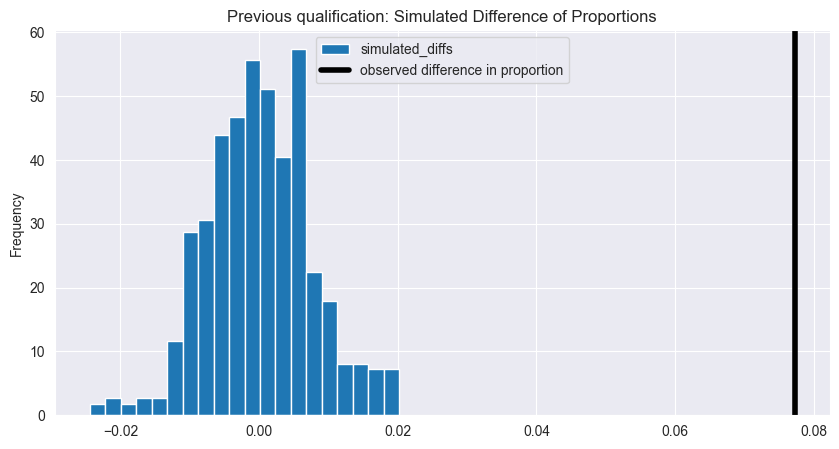

In [109]:
(pd.DataFrame()
 .assign(simulated_diffs=simulated_diffs)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(sample_stat, color='black', linewidth=4, label='observed difference in proportion')
plt.title('Previous qualification: Simulated Difference of Proportions')
plt.legend();

In [108]:
prev_qual_pval = np.count_nonzero(simulated_diffs >= sample_stat) / n
prev_qual_pval

0.0

In [110]:
statsmodels.stats.proportion.proportions_ztest(
    count = [
        df1_drop['Previous qualification'].map(lambda x: (x == 'Below secondary').sum() ,
        df1_grad['Previous qualification'].map(lambda x: (x == 'Below secondary').sum() 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = 'larger'
)

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 4 (8101251.py, line 5)